In [32]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss
from beeid2.data_utils import filename2image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

TEST_CSV = "/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv"

batch_size=32

def to_np_array(values, dim=128):
    return np.concatenate(list(values)).reshape(-1, dim)

def get_shortterm_mean_dist(test_df):    
    gtracks = test_df.groupby("global_track_id").filter(lambda x: len(x) > 1)
    means = list()
    for tid in gtracks.global_track_id.unique():
        track_embs = gtracks[gtracks.global_track_id == tid].emb.values
        track_embs = to_np_array(track_embs)
        dmatrix = 1 - tf.matmul(track_embs, track_embs.T).numpy()
        distances = dmatrix[np.triu_indices(dmatrix.shape[0], k = 1)].mean()
        means.append(distances)
    print(f"short-term comparisons: {len(means)}")
    return np.mean(means), means

def get_shortterm_diameter(test_df):    
    gtracks = test_df.groupby("global_track_id").filter(lambda x: len(x) > 1)
    means = list()
    for tid in gtracks.global_track_id.unique():
        track_embs = gtracks[gtracks.global_track_id == tid].emb.values
        track_embs = to_np_array(track_embs)
        dmatrix = 1 - tf.matmul(track_embs, track_embs.T).numpy()
        distances = dmatrix[np.triu_indices(dmatrix.shape[0], k = 1)].max()
        means.append(distances)
    return np.mean(means), means

def get_longterm_mean_dist(test_df):
    timegap=15
    timegap_unit="m"
    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    distances = []
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))
    count = 0
    queries_num = 0
    tag_id_dist = defaultdict(lambda: np.array([]))

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap

        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track)]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue

        tag_id = query_row.track_tag_id
        gtrack_dist = np.array([])

        gallery = to_np_array(gallery_df["emb"].values)
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = 1 - tf.matmul(query, gallery.T).numpy()
            distances = np.squeeze(distances)
            gtrack_dist = np.append(gtrack_dist, distances)
            count += 1
        tag_id_dist[tag_id] = np.append(tag_id_dist[tag_id],  gtrack_dist)
    print(f"long-term comparisons: {count}")
    mean_per_tag_id = [np.mean(ds) for ds in tag_id_dist.values()]
    return np.mean(mean_per_tag_id), mean_per_tag_id

def get_longterm_diameter(test_df):
    timegap=15
    timegap_unit="m"
    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()

    distances = []
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))

    queries_num = 0
    tag_id_dist = defaultdict(lambda: np.array([]))

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap

        gallery_df = test_df[(is_enough_timegap & is_same_id & ~ is_same_track)]
        if np.sum(gallery_df.track_tag_id == query_row.track_tag_id) == 0:
            continue

        tag_id = query_row.track_tag_id
        gtrack_dist = np.array([])

        gallery = to_np_array(gallery_df["emb"].values)
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = 1 - tf.matmul(query, gallery.T).numpy()
            distances = np.squeeze(distances)
            gtrack_dist = np.append(gtrack_dist, distances)
        tag_id_dist[tag_id] = np.append(tag_id_dist[tag_id],  gtrack_dist)

    mean_per_tag_id = [np.max(ds) for ds in tag_id_dist.values()]
    return np.mean(mean_per_tag_id), mean_per_tag_id


def get_notsame_mean_dist(test_df):
    timegap=15
    timegap_unit="m"
    gtracks = test_df.groupby("track_tag_id").filter(lambda x: len(x["global_track_id"].unique()) > 1)
    gtracks = gtracks.global_track_id.unique()
    count = 0
    distances = []
    eval_tracks = len(gtracks)
    print("Evaluating {} tracks.".format(eval_tracks))

    queries_num = 0
    tag_id_dist = defaultdict(lambda: np.array([]))

    for gtrack in tqdm(gtracks):
        is_same_track = (test_df.global_track_id == gtrack)
        im_tracks = test_df[is_same_track]
        query_row = im_tracks.iloc[0]
        is_same_id = (query_row.track_tag_id == test_df.track_tag_id)
        is_enough_timegap = np.abs(test_df.datetime2 - query_row.datetime2).astype('timedelta64[{}]'.format(timegap_unit)) > timegap

        gallery_df = test_df[~ is_same_id]

        tag_id = query_row.track_tag_id
        gtrack_dist = np.array([])

        gallery = to_np_array(gallery_df["emb"].values)
        for _, row in im_tracks.iterrows():
            query_id = row.track_tag_id
            query = np.expand_dims(row.emb, axis=0)
            distances = 1 - tf.matmul(query, gallery.T).numpy()
            distances = np.squeeze(distances)
            gtrack_dist = np.append(gtrack_dist, distances)
            count += 1
        tag_id_dist[tag_id] = np.append(tag_id_dist[tag_id],  gtrack_dist)
    print(f"not-same comparisons: {count}")
    mean_per_tag_id = [np.mean(ds) for ds in tag_id_dist.values()]
    return np.mean(mean_per_tag_id), mean_per_tag_id

def eval_model_short_long_term(model_path):
    model = load_model(model_path, custom_objects={'tf': tf})

    test_df = pd.read_csv(TEST_CSV)
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    shortterm_mean_dist, short_distribution = get_shortterm_mean_dist(test_df)
    longterm_mean_dist, long_distribution = get_longterm_mean_dist(test_df)
    notsame_mean_dist, notsame_distribution = get_notsame_mean_dist(test_df)
    return shortterm_mean_dist, short_distribution, longterm_mean_dist, long_distribution, notsame_mean_dist, notsame_distribution


def eval_model_short_long_diameter(model_path):
    model = load_model(model_path, custom_objects={'tf': tf})

    test_df = pd.read_csv(TEST_CSV)
    test_df["datetime2"] = pd.to_datetime(test_df["datetime"])

    filenames = test_df["filename"].values
    images = filename2image(filenames)
    predictions = model.predict(images.batch(batch_size), verbose=True)
    test_df["emb"]  = list(predictions)

    shortterm_diameter, short_distribution = get_shortterm_diameter(test_df)
    longterm_diameter, long_distribution = get_longterm_diameter(test_df)

    return shortterm_diameter, short_distribution, longterm_diameter, long_distribution

In [33]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

In [34]:
models = dict()
ntracks = [181, 362, 724, 1448, 2896]
for ntrack in ntracks:
    models[ntrack] = "/home/jchan/beeid/notebooks/cmc_experiments/models3/211006{:04}_untagged_augmentation_simplecnnv2_convb3_dim_128/model.tf".format(ntrack)
models[4949] = "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111231639_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf"

In [35]:
benchmark = defaultdict(dict)

for ntrack, model_path in models.items():
    shortterm_mean_dist, short_distribution, longterm_mean_dist, long_distribution, notsame_mean_dist, notsame_distribution = eval_model_short_long_term(model_path)
    shortterm_diameter, short_diameter_distribution, longterm_diameter, long_diameter_distribution = eval_model_short_long_diameter(model_path)

    benchmark[ntrack]["shortterm_mean"] = shortterm_mean_dist
    benchmark[ntrack]["shortterm_hist"] = short_distribution
    benchmark[ntrack]["shortterm_diameter_mean"] = shortterm_diameter
    benchmark[ntrack]["shortterm_diameter_hist"] = short_diameter_distribution
    
    benchmark[ntrack]["longterm_mean"] = longterm_mean_dist
    benchmark[ntrack]["longterm_hist"] = long_distribution
    benchmark[ntrack]["longterm_diameter_mean"] = longterm_diameter
    benchmark[ntrack]["longterm_diameter_hist"] = long_diameter_distribution
    
    benchmark[ntrack]["notsame_mean"] = notsame_mean_dist
    benchmark[ntrack]["notsame_hist"] = notsame_distribution


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 196.81it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  3%|▎         | 17/654 [00:00<00:03, 160.30it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 58.84it/s]


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 25/654 [00:00<00:02, 247.34it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 159.04it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  3%|▎         | 18/654 [00:00<00:03, 179.19it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  2%|▏         | 16/654 [00:00<00:04, 158.93it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:13<00:00, 50.06it/s]


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  2%|▏         | 14/654 [00:00<00:04, 133.83it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 152.34it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  2%|▏         | 14/654 [00:00<00:04, 132.69it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  3%|▎         | 17/654 [00:00<00:03, 159.45it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 54.02it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  3%|▎         | 19/654 [00:00<00:03, 184.39it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 134.60it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 26/654 [00:00<00:02, 258.92it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  3%|▎         | 17/654 [00:00<00:03, 160.93it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:08<00:00, 74.51it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 27/654 [00:00<00:02, 261.06it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 149.46it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 26/654 [00:00<00:02, 258.35it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  3%|▎         | 17/654 [00:00<00:03, 163.92it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:08<00:00, 73.91it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  2%|▏         | 15/654 [00:00<00:04, 143.33it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 160.74it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 26/654 [00:00<00:02, 251.35it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  2%|▏         | 16/654 [00:00<00:04, 158.76it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 55.87it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 26/654 [00:00<00:02, 257.23it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 161.10it/s]


In [38]:
for ntrack in ntracks:
    print(ntrack, benchmark[ntrack]['shortterm_mean'], benchmark[ntrack]['longterm_mean'])

181 0.21730149 0.4980843684251885
362 0.36172116 0.7119656560149054
724 0.38222286 0.7442238385975367
1448 0.27568176 0.6020077908895555
2896 0.24691716 0.5661057748808626


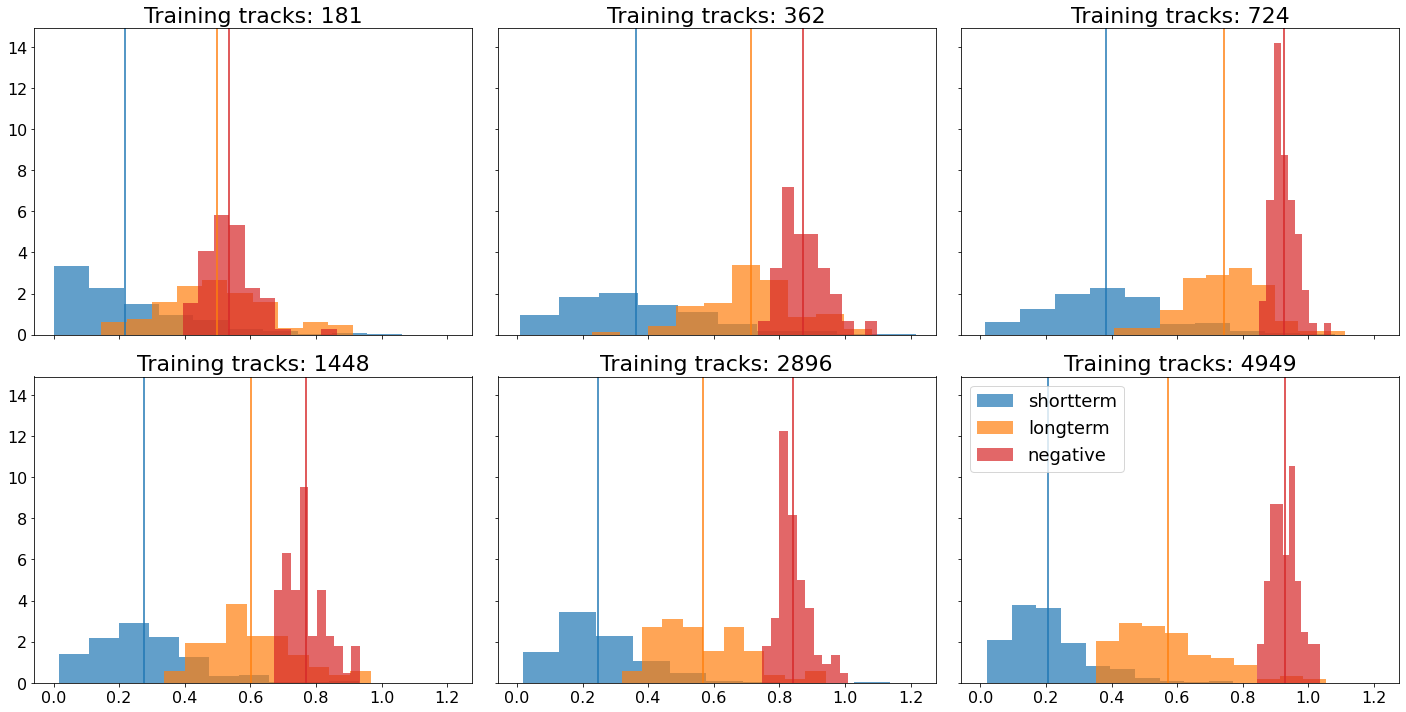

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20, 10))
axes = ax.ravel()
for i, ntrack in enumerate(benchmark.keys()):
    axes[i].set_title("Training tracks: {}".format(ntrack), fontsize=22)
    axes[i].hist(benchmark[ntrack]["shortterm_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["shortterm_mean"], color="tab:blue")
    
    axes[i].hist(benchmark[ntrack]["longterm_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["longterm_mean"], color="tab:orange")
    
    axes[i].hist(benchmark[ntrack]["notsame_hist"], label="negative", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["notsame_mean"], color="tab:red")
plt.legend(fontsize=18);
plt.tight_layout()

plt.savefig("distancedistribution_ntracks.png", bbox_inches='tight')

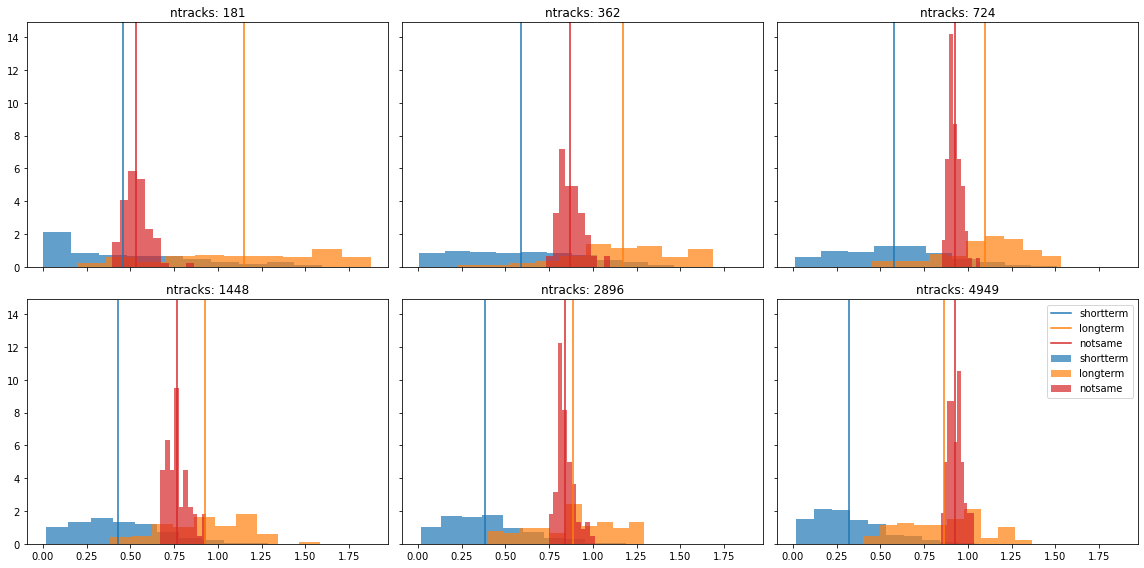

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, ntrack in enumerate(benchmark.keys()):
    axes[i].set_title("ntracks: {}".format(ntrack))
    axes[i].hist(benchmark[ntrack]["shortterm_diameter_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["shortterm_diameter_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark[ntrack]["longterm_diameter_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["longterm_diameter_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark[ntrack]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("diameterdistribution_ntracks.png", bbox_inches='tight')


In [ ]:
models = {
    "tagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240358_tagged_simplecnnv2_convb3_dim_128/model.tf",
    "untagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232311_untagged_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_untagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111241016_tagged_untagged_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_augmentataion": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232233_tagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
    "untagged_augmentation": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111231639_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_augmentataion_untagged_augmentataion":"/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
}

benchmark2 = defaultdict(dict)

for model_name, model_path in models.items():
    shortterm_mean_dist, short_distribution, longterm_mean_dist, long_distribution, notsame_mean_dist, notsame_distribution = eval_model_short_long_term(model_path)
    shortterm_diameter, short_diameter_distribution, longterm_diameter, long_diameter_distribution = eval_model_short_long_diameter(model_path)

    benchmark2[model_name]["shortterm_mean"] = shortterm_mean_dist
    benchmark2[model_name]["shortterm_hist"] = short_distribution
    benchmark2[model_name]["shortterm_diameter_mean"] = shortterm_diameter
    benchmark2[model_name]["shortterm_diameter_hist"] = short_diameter_distribution
    
    benchmark2[model_name]["longterm_mean"] = longterm_mean_dist
    benchmark2[model_name]["longterm_hist"] = long_distribution
    benchmark2[model_name]["longterm_diameter_mean"] = longterm_diameter
    benchmark2[model_name]["longterm_diameter_hist"] = long_diameter_distribution
    
    benchmark2[model_name]["notsame_mean"] = notsame_mean_dist
    benchmark2[model_name]["notsame_hist"] = notsame_distribution
    

/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  4%|▍         | 27/654 [00:00<00:02, 268.76it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  3%|▎         | 17/654 [00:00<00:03, 162.29it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:09<00:00, 71.78it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 28/654 [00:00<00:02, 275.46it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 151.94it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 11ms/step


  4%|▍         | 27/654 [00:00<00:02, 262.58it/s]

short-term comparisons: 413
Evaluating 654 tracks.


  2%|▏         | 16/654 [00:00<00:04, 157.92it/s]

long-term comparisons: 3173
Evaluating 654 tracks.


100%|██████████| 654/654 [00:09<00:00, 72.33it/s] 


not-same comparisons: 3191


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [27]:
model_name_dict = {
    "tagged": "long-term",
    "untagged": "short-term",
    "tagged_untagged": "short-term + long-term",
    "tagged_augmentataion": "long-term + augmentation",
    "untagged_augmentation": "short-term + augmentation",
    "tagged_augmentataion_untagged_augmentataion": "short-term + long-term + augmentation",
}

In [26]:
models

{'tagged': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240358_tagged_simplecnnv2_convb3_dim_128/model.tf',
 'untagged': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232311_untagged_simplecnnv2_convb3_dim_128/model.tf',
 'tagged_untagged': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111241016_tagged_untagged_simplecnnv2_convb3_dim_128/model.tf',
 'tagged_augmentataion': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232233_tagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf',
 'untagged_augmentation': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111231639_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf',
 'tagged_augmentataion_untagged_augmentataion': '/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf'}

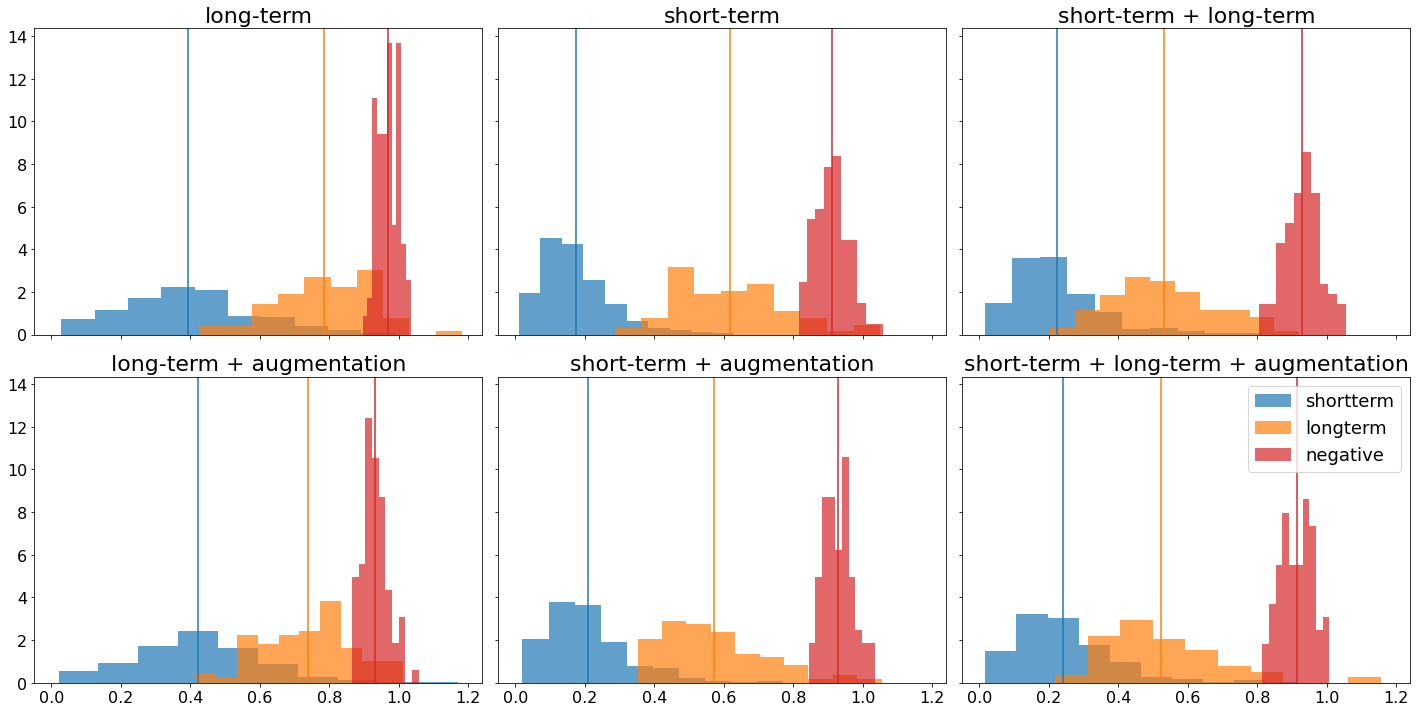

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20, 10))
axes = ax.ravel()
for i, model_name in enumerate(models.keys()):
    axes[i].set_title("{}".format(model_name_dict[model_name]), fontsize=22)
    axes[i].hist(benchmark2[model_name]["shortterm_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["shortterm_mean"], color="tab:blue")
    
    axes[i].hist(benchmark2[model_name]["longterm_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["longterm_mean"], color="tab:orange")
    
    axes[i].hist(benchmark2[model_name]["notsame_hist"], label="negative", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["notsame_mean"], color="tab:red")
plt.tight_layout()
plt.legend(fontsize=18);
plt.savefig("distancedistribution.png", bbox_inches="tight")

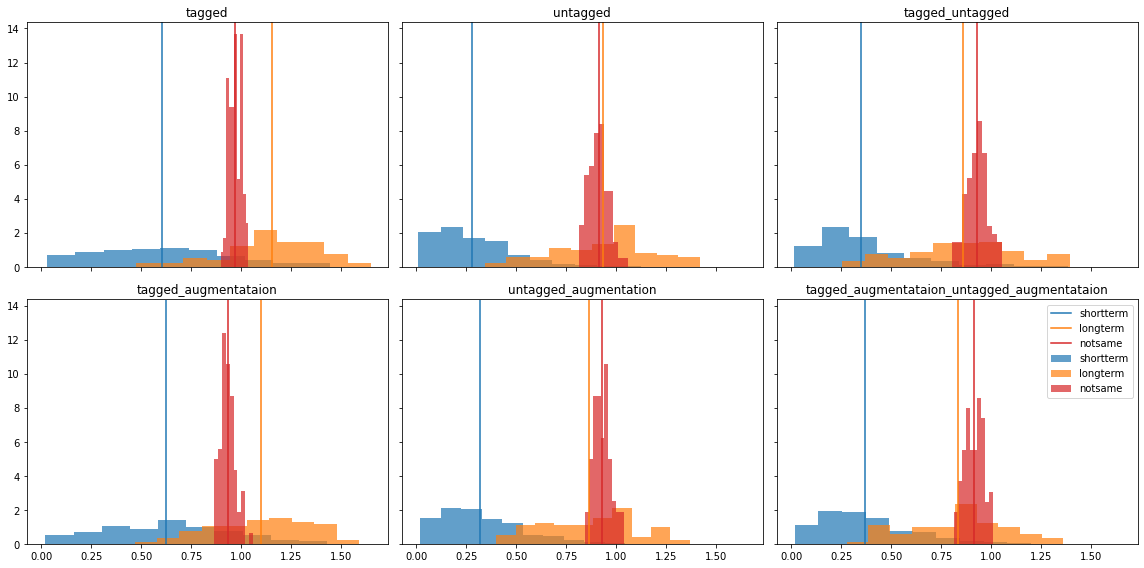

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, model_name in enumerate(models.keys()):
    axes[i].set_title("{}".format(model_name))
    axes[i].hist(benchmark2[model_name]["shortterm_diameter_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["shortterm_diameter_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark2[model_name]["longterm_diameter_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["longterm_diameter_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark2[model_name]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("diameterdistribution.png")